
Trains a denoising autoencoder on MNIST dataset.<br>
Denoising is one of the classic applications of autoencoders.<br>
The denoising process removes unwanted noise that corrupted the<br>
true data.<br>
Noise + Data ---> Denoising Autoencoder ---> Data<br>
Given a training dataset of corrupted data as input and<br>
true data as output, a denoising autoencoder can recover the<br>
hidden structure to generate clean data.<br>
This example has modular design. The encoder, decoder and autoencoder<br>
are 3 models that share weights. For example, after training the<br>
autoencoder, the encoder can be used to  generate latent vectors<br>
of input data for low-dim visualization like PCA or TSNE.<br>


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/Users/jonasgacrama/miniconda/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(1337)

load MNIST dataset

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

reshape to (28, 28, 1) and normalize input images

In [5]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

generate corrupted MNIST images by adding noise with normal dist<br>
centered at 0.5 and std=0.5

In [6]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

adding noise may exceed normalized pixel values>1.0 or <0.0<br>
clip pixel values >1.0 to 1.0 and <0.0 to 0.0

In [7]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

network parameters

In [8]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

build the autoencoder model<br>
first build the encoder model

In [9]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

stack of Conv2D(32)-Conv2D(64)

In [10]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-13 17:22:09.849140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-13 17:22:09.849265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


shape info needed to build decoder model so we don't do hand computation<br>
the input to the decoder's first Conv2DTranspose will have this shape<br>
shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)

In [11]:
shape = K.int_shape(x)

generate the latent vector

In [12]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

instantiate encoder model

In [13]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


build the decoder model

In [14]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

stack of Conv2DTranspose(64)-Conv2DTranspose(32)

In [15]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

reconstruct the denoised input

In [16]:
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

instantiate decoder model

In [17]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289 

autoencoder = encoder + decoder<br>
instantiate autoencoder model

In [18]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69008     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         108993    
                                                                 
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


Mean Square Error (MSE) loss function, Adam optimizer

In [19]:
autoencoder.compile(loss='mse', optimizer='adam')

train the autoencoder

In [20]:
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size)

Epoch 1/10


2022-11-13 17:22:10.588670: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-13 17:22:10.915995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1872/1875 [============================>.] - ETA: 0s - loss: 0.0343

2022-11-13 17:22:29.370997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 21s 10ms/step - loss: 0.0343 - val_loss: 0.0200
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0191 - val_loss: 0.0178
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0176 - val_loss: 0.0170
Epoch 4/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 5/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 6/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0157 - val_loss: 0.0159
Epoch 8/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 9/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 10/10
1875/1875 [==============================] - 19s 10ms/step - lo

predict the autoencoder output from corrupted test images

In [21]:
x_decoded = autoencoder.predict(x_test_noisy)

 28/313 [=>............................] - ETA: 1s

2022-11-13 17:25:21.308691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step


3 sets of images with 9 MNIST digits<br>
1st rows - original images<br>
2nd rows - images corrupted by noise<br>
3rd rows - denoised images

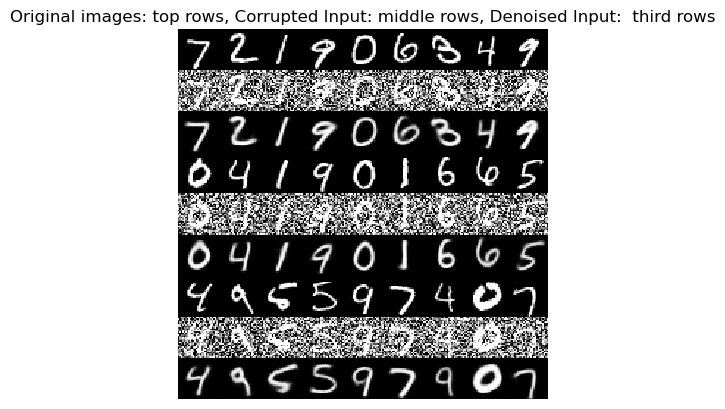

In [22]:
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()